# Sigmoid Token Bonding Curve

![TBC Template #1 : Static price for pre-sale, linear curve for market maturity phase](./curves/sigmoidCurve.png)

![Sigmoid Function Equation](./curves/sigmoidFunction2.png)

- **a (height of the curve)** -- could be increased to raise the maximum price of the token if demand is higher than expected
- **b (token supply at the inflection point)** -- could be lowered to shift the inflection point to a lower level of token supply if the market is not accelerating.
- **c (supply range in which the token price appreciates)** -- could be flattened to reduce token price volatility as demand climbs the most upward slope of the curve.
- **m (vertical position of the curve)** -- could be adjusted in response to the fiat value of the token to stabilize its value in the real world.

##### Sigmoid Function : Pricing function and area under the curve functions

This template uses the following exchange pricing function - 

![Sigmoid Function Equation](./curves/sigmoidFunction2.png)

We need the integral of the above function to calculate the number of RLY tokens that will be needed to mint / burn against the CCs being transacted per transaction. 

The integration can be referred to below : 

![Sigmoid Function Integration](./curves/sigmoidFunctionIntegration.png)

You can try out different parameter values to see how the curve behaves here - [https://www.desmos.com/calculator/j1yxue0euk](https://www.desmos.com/calculator/j1yxue0euk)


In [1]:
import math
import time
from scipy.stats import norm
import numpy as np
from datetime import date,datetime,timedelta, timezone
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Parameters
total_CC_Supply = 210000           
genesis_supply = 50000              # 50 thousand

totalRallyLocked = 0    
RLY_total_locked_target = 5000000          # 5 Million

In [3]:
df = pd.DataFrame([], columns = ['date', 'timestamp','CC To be Minted','RLY To be Locked',
                                 'CCs : Price (RLY)','CCs : Delta Supply','CCs : Total Supply',
                                 'RLY : Delta Locked','RLY : Total Locked',
                                 '+2% depth: CCs Minted','+2% depth: RLY Locked','+2% depth: RLY/CC',
                                 '-2% depth: CCs Burnt','-2% depth: RLY Un-Locked','-2% depth: RLY/CC',
                                 'Reserve Ratio','Note']) 
df['date'] = pd.to_datetime(df['date'],format='%d/%m/%Y')

unix = datetime(1970, 1, 1)
cur_  = datetime(2021, 1, 1)

deltaTime = timedelta(minutes=1)

##### Adding first row (Phase 0)

In [4]:
df.loc[0] = [pd.to_datetime(cur_,format='%d/%m/%Y'),int((cur_ - unix).total_seconds()),total_CC_Supply,RLY_total_locked_target
                         ,0,0,0,0,0,0,0,0,0,0,0,0,'uninitialized state']

In [5]:
# display(df)

## Genesis Supply

In [6]:
gen_percent_of_total = genesis_supply/total_CC_Supply * 100
print('Genesis Supply = ',genesis_supply,' CCs, which equals ',
      round(gen_percent_of_total,2),'% of the total CCs supply cap of '      ,total_CC_Supply )

Genesis Supply =  50000  CCs, which equals  23.81 % of the total CCs supply cap of  210000


##### Adding 2nd row : State after Genesis Mint

In [7]:
cur_ = cur_ + deltaTime
df.loc[len(df.index)] = [pd.to_datetime(cur_,format='%d/%m/%Y'),int((cur_ - unix).total_seconds()),
                         total_CC_Supply - genesis_supply,RLY_total_locked_target,0,genesis_supply,genesis_supply,0,0,0,0,0,0,0,0,0,'Genesis Mint']

In [19]:
# display(df)

## Sigmoid Function based TBC
![Sigmoid Function Equation](./curves/sigmoidFunction2.png)

- **a (height of the curve)** -- could be increased to raise the maximum price of the token if demand is higher than expected
- **b (token supply at the inflection point)** -- could be lowered to shift the inflection point to a lower level of token supply if the market is not accelerating.
- **c (supply range in which the token price appreciates)** -- could be flattened to reduce token price volatility as demand climbs the most upward slope of the curve.
- **m (vertical position of the curve)** -- could be adjusted in response to the fiat value of the token to stabilize its value in the real world.

In [9]:
def getNormalDistributionValues(mean, deviation, numberOfPoints) :
    normalPoints_ =  np.random.normal(mean, deviation, numberOfPoints)
    return normalPoints_

In [11]:
def getCurrentPrice(a,b,c,m,curCCSupply): 
    den = c + math.pow(curCCSupply + b,2)
    price = a*( ((curCCSupply + b)/(math.sqrt(den))) + m )
#     print('\n' + ' a =' + str(a) + ' b =' + str(b) + ' c =' + str(c) + ' m =' + str(m) + ' curCCSupply = ' + str(curCCSupply)
#           + ' den = ' + str(den) + ' price =' + str(price))
    return price

In [12]:
def costOfMinting(a,b,c,m,prevCCSupply,newCCSupply): 
    # current supply     
    num = c + math.pow(prevCCSupply + b,2)
    partA = math.sqrt(num/c)
    partB = m*((prevCCSupply + b) / math.sqrt(c))
    prevSupplyIntegral = a*math.sqrt(c)*( partA + partB)
    # new supply     
    num = c + math.pow(newCCSupply + b,2)
    partA = math.sqrt(num/c)
    partB = m*((newCCSupply + b) / math.sqrt(c))
    newSupplyIntegral = a*math.sqrt(c)*( partA + partB)
    
    ans = newSupplyIntegral - prevSupplyIntegral
    return ans

In [13]:
a = 11              # height of the curve -- could be increased to raise the maximum price
b = -145000      # token supply at the inflection point
c = 309500000       # supply range in which the token price appreciates
m = 1            # vertical position of the curve

In [14]:
priceDF = pd.DataFrame([], columns = ['CC Supply','Price']) 
cc_supply_ = genesis_supply

while cc_supply_ < total_CC_Supply:
    delta = 5000
    cc_supply_ = cc_supply_ + delta
    price = getCurrentPrice(a,b,c,m,cc_supply_)
    
    priceDF.loc[len(priceDF.index)] = [cc_supply_,price]
    
max_CC_Price = priceDF.loc[len(priceDF.index) - 1,'Price']
print('Final Price of Creator Coins will be ' + str(max_CC_Price) + ' RLY')

Final Price of Creator Coins will be 21.61796620390178 RLY


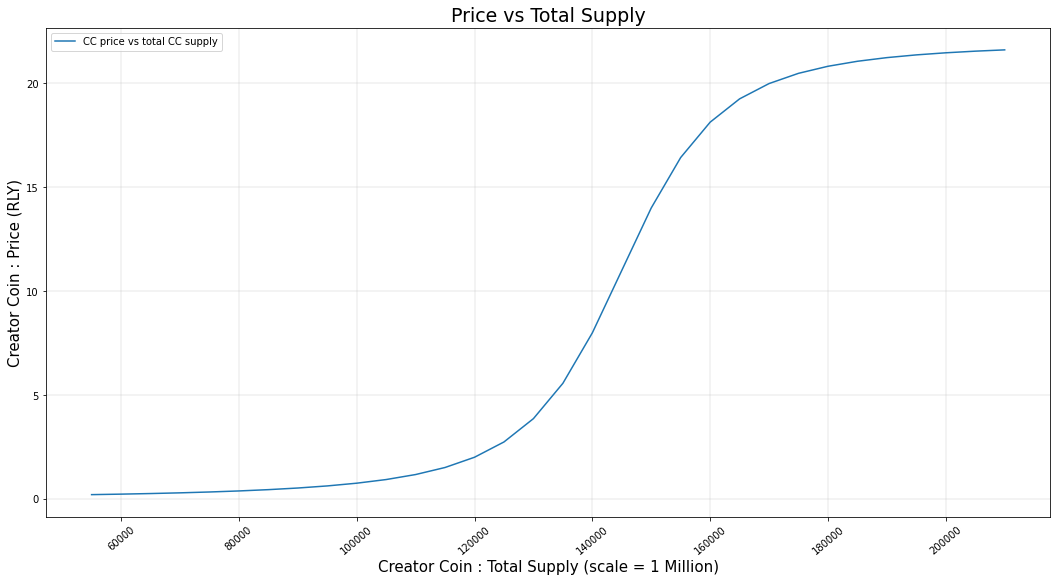

In [15]:
plt.figure(figsize=(18,9))
plt.xticks(rotation=40)
plt.grid(linewidth=0.3)
plt.plot(priceDF.loc[:,'CC Supply'],priceDF.loc[:,'Price'],label='CC price vs total CC supply')
plt.xlabel('Creator Coin : Total Supply (scale = 1 Million)',fontsize = 15)
plt.ylabel('Creator Coin : Price (RLY)',fontsize = 15)
plt.title('Price vs Total Supply',fontsize = 19)
plt.legend()
# plt.savefig('./images/large_CC_TBC/4_Price_vs_Supply.png')

In [21]:
# display(priceDF)

## Automated Liquidity via the Sigmoid Bonding Curve

- The following math shows how to calculate Creator Coin supply for after a transaction which will increase the CC price by 2%

![(+2) % Depth : Final CC supply](./curves/PosDepth.png)

- The following math shows how to calculate Creator Coin supply for after a transaction which will decrease the CC price by 2%

![(-2) % Depth : Final CC supply](./curves/NegDepth.png)

In [22]:
def getNewCCSupplyPosDepth(a,b,c,m,currentCCSupply):
    t = 1.02*(currentCCSupply + b) / math.sqrt(c + math.pow(currentCCSupply + b,2) )
    num = math.sqrt(c)*(0.02*m + t)
    den = math.sqrt( 1 - math.pow(0.02*m + t,2))
    newCCSupply = (num/den) - b
    return newCCSupply

def getNewCCSupplyNegDepth(a,b,c,m,currentCCSupply):
    t = 0.98*(currentCCSupply + b) / math.sqrt(c + math.pow(currentCCSupply + b,2) )
    num = math.sqrt(c)*(t - 0.02*m)
    den = math.sqrt( 1 - math.pow(t - 0.02*m,2))
    newCCSupply = (num/den) - b
    return newCCSupply

In [23]:
# CCSupply = 9463074
# newCCSupply = getNewCCSupplyPosDepth(a,b,c,m,CCSupply)

In [24]:
CCstobeMinted = df.loc[len(df.index)-1,'CC To be Minted']
    
deltaSupplies = getNormalDistributionValues(700, 1000,1000)
i =0
    
while CCstobeMinted > 0:
    cur_ = cur_ + deltaTime  # date updated

    if i < 1000:
        CC_deltaSupply = deltaSupplies[i]
        i = i + 1
    else :
        deltaSupplies = getNormalDistributionValues(700, 1000,1000)
        i = 0
        CC_deltaSupply = deltaSupplies[i]
    
    total_CCs_to_be_minted = df.loc[len(df.index)-1,'CC To be Minted'] - CC_deltaSupply
    CC_totalSupply = df.loc[len(df.index)-1,'CCs : Total Supply'] + CC_deltaSupply
    
    # functional calculation      
    CC_price_RLY = getCurrentPrice(a,b,c,m,CC_totalSupply)
    mintCost_RLY = costOfMinting(a,b,c,m,df.loc[len(df.index)-1,'CCs : Total Supply'],CC_totalSupply)
    
#     print(' a = ' + str(a) + ' b = ' + str(b) + ' c = ' + str(c) + ' m = ' + str(m) + 
#           ' CC Price ' + str(round(CC_price_RLY,2)) + ' RLY Needed ' + str(round(mintCost_RLY,2)) + 
#          'CC Current Supply = ' + str(CC_totalSupply) )
    
    if CC_price_RLY < 0.98*max_CC_Price:
        pos_depth_CC_minted = getNewCCSupplyPosDepth(a,b,c,m,CC_totalSupply) - CC_totalSupply 
        pos_depth_RLY_locked = costOfMinting(a,b,c,m,CC_totalSupply,pos_depth_CC_minted + CC_totalSupply)
        pos_depth_RLY_per_CC = round(pos_depth_RLY_locked/pos_depth_CC_minted,3)
    else :
        pos_depth_CC_minted = 0
        pos_depth_RLY_locked = 0
        pos_depth_RLY_per_CC = 0
        
    
#     print('Prev CC Supply = ' + str(CC_totalSupply) + ' New CC Supply = ' + str(CC_totalSupply + pos_depth_CC_minted) + ' Delta CC Supply = ' + str(pos_depth_CC_minted))

    neg_depth_CC_burnt = CC_totalSupply - getNewCCSupplyNegDepth(a,b,c,m,CC_totalSupply) 
    neg_depth_RLY_unlocked = -1*costOfMinting(a,b,c,m,CC_totalSupply,CC_totalSupply - neg_depth_CC_burnt)
    neg_depth_RLY_per_CC = round(neg_depth_RLY_unlocked/neg_depth_CC_burnt,3)

#     print('Prev CC Supply = ' + str(CC_totalSupply) + ' New CC Supply = ' + str(CC_totalSupply - neg_depth_CC_burnt) + ' Delta CC Supply = ' + str(neg_depth_CC_burnt))
    
    RLY_DeltaLocked = mintCost_RLY
    RLY_TotalLocked = df.loc[len(df.index)-1,'RLY : Total Locked'] + RLY_DeltaLocked
    total_RLY_to_be_locked = df.loc[len(df.index)-1,'RLY To be Locked'] - RLY_DeltaLocked
    reserve_ratio = RLY_TotalLocked / CC_totalSupply
    
    if CC_deltaSupply > 0 :
        note = 'Mint Transaction'
    else :
        note = 'Burn Transaction'

    df.loc[len(df.index)] = [pd.to_datetime(cur_,format='%d/%m/%Y'),int((cur_ - unix).total_seconds()),
                             total_CCs_to_be_minted,total_RLY_to_be_locked, CC_price_RLY, CC_deltaSupply, CC_totalSupply,
                             RLY_DeltaLocked,RLY_TotalLocked,pos_depth_CC_minted,pos_depth_RLY_locked,pos_depth_RLY_per_CC,
                             neg_depth_CC_burnt,neg_depth_RLY_unlocked,neg_depth_RLY_per_CC,
                             reserve_ratio,note]
    
    CCstobeMinted = df.loc[len(df.index)-1,'CC To be Minted']

In [28]:
# display(df)

In [26]:
metrics = df

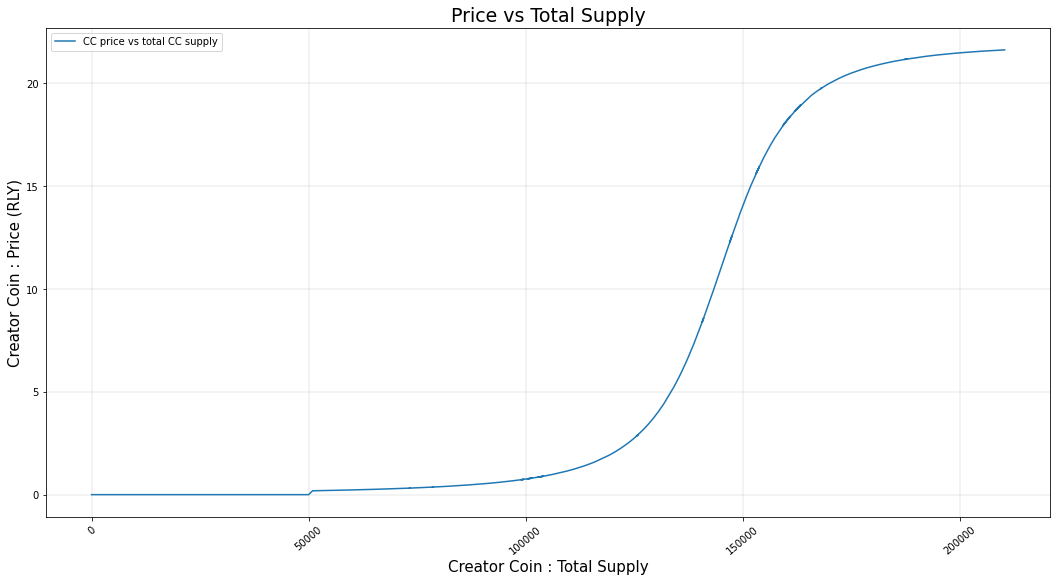

In [298]:
plt.figure(figsize=(18,9))
plt.xticks(rotation=40)
plt.grid(linewidth=0.3)
plt.plot(metrics.loc[:,'CCs : Total Supply'],metrics.loc[:,'CCs : Price (RLY)'],label='CC price vs total CC supply')
plt.xlabel('Creator Coin : Total Supply',fontsize = 15)
plt.ylabel('Creator Coin : Price (RLY)',fontsize = 15)
plt.title('Price vs Total Supply',fontsize = 19)
plt.legend()
# plt.savefig('./images/large_CC_TBC/4_Price_vs_Supply.png')

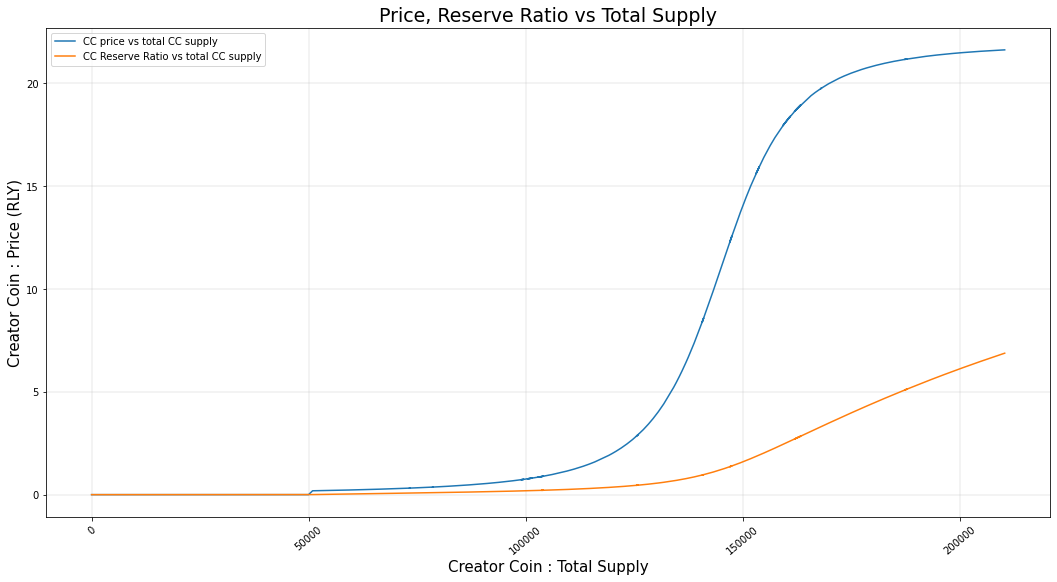

In [299]:
plt.figure(figsize=(18,9))
plt.xticks(rotation=40)
plt.grid(linewidth=0.3)
plt.plot(metrics.loc[:,'CCs : Total Supply'],metrics.loc[:,'CCs : Price (RLY)'],label='CC price vs total CC supply')
plt.plot(metrics.loc[:,'CCs : Total Supply'],metrics.loc[:,'Reserve Ratio'],label='CC Reserve Ratio vs total CC supply')

plt.xlabel('Creator Coin : Total Supply',fontsize = 15)
plt.ylabel('Creator Coin : Price (RLY)',fontsize = 15)
plt.title('Price, Reserve Ratio vs Total Supply',fontsize = 19)
plt.legend()
# plt.savefig('./images/large_CC_TBC/4_Price_Reserve_Ratio_vs_Supply.png')

In [302]:
# plt.figure(figsize=(18,9))
# plt.xticks(rotation=40)
# plt.grid(linewidth=0.3)
# plt.plot(metrics.loc[:,'CCs : Total Supply'],label='CCs : Total Supply')
# plt.plot(metrics.loc[:,'RLY : Total Locked'],label='RLY : Total Locked')
# plt.xlabel('timestamps (simulated)',fontsize = 15)
# plt.ylabel('Total Supply',fontsize = 15)
# plt.title('Total Creator Coins, RLY Locked vs Time',fontsize = 19)
# plt.legend()
# # plt.savefig('./images/large_CC_TBC/4_supplies_vs_time.png')

In [303]:
# metrics.head(4)

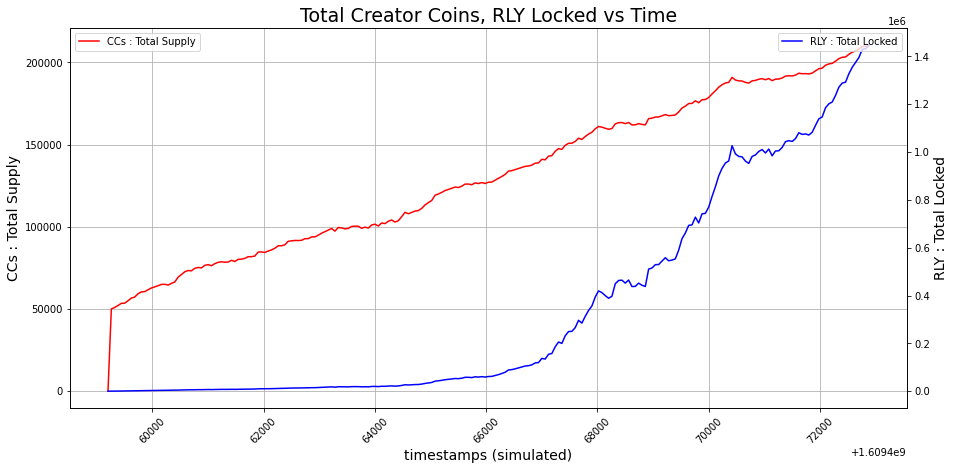

In [304]:
fig,ax = plt.subplots(figsize=(15, 7))
plt.xticks(rotation=45)
plt.title('Total Creator Coins, RLY Locked vs Time',fontsize = 19)

ax.plot( metrics['timestamp'],metrics['CCs : Total Supply'], '-r',label="CCs : Total Supply")
ax.set_xlabel("timestamps (simulated)",fontsize=14)
ax.set_ylabel("CCs : Total Supply",fontsize=14)
ax.legend(loc='upper left')
ax.grid(True)

ax2=ax.twinx()
ax2.plot( metrics['timestamp'],metrics['RLY : Total Locked'],'-b',label="RLY : Total Locked")
ax2.set_ylabel("RLY : Total Locked",fontsize=14)
ax2.legend(loc='upper right')

In [305]:
# plt.figure(figsize=(18,9))
# plt.xticks(rotation=40)
# plt.grid(linewidth=0.3)
# plt.plot(metrics[metrics['+2% depth: CCs Minted']>0].loc[:,'CCs : Total Supply'],metrics[metrics['+2% depth: CCs Minted']>0].loc[:,'+2% depth: CCs Minted'],label='+2% depth: CCs Minted')
# plt.plot(metrics[metrics['+2% depth: RLY Locked']>0].loc[:,'CCs : Total Supply'],metrics[metrics['+2% depth: RLY Locked']>0].loc[:,'+2% depth: RLY Locked'],label='+2% depth: RLY Locked')

# plt.xlabel('CCs : Total Supply',fontsize = 15)
# plt.ylabel('Delta Supply (Millions)',fontsize = 15)
# plt.title('+ 2% Price Depth : delta CCs minted, RLY Locked vs Total CC Supply',fontsize = 19)
# plt.legend()
# # plt.savefig('./images/large_CC_TBC/4_posDepthDeltaCC_RLY_vs_TotalCCSupply.png')

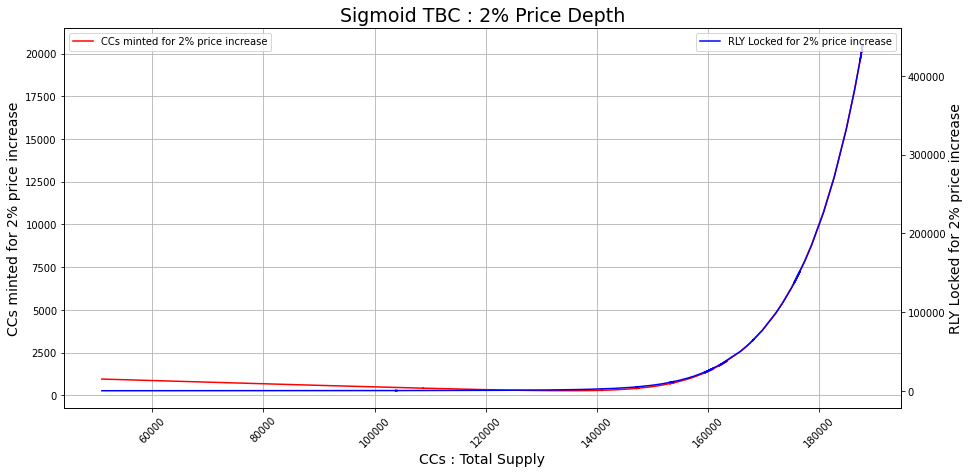

In [306]:
fig,ax = plt.subplots(figsize=(15, 7))
plt.xticks(rotation=45)
plt.title("Sigmoid TBC : 2% Price Depth",fontsize = 19)
ax.plot(metrics[metrics['+2% depth: CCs Minted']>0].loc[:,'CCs : Total Supply'],metrics[metrics['+2% depth: CCs Minted']>0].loc[:,'+2% depth: CCs Minted'], '-r',label="CCs minted for 2% price increase")
ax.set_xlabel("CCs : Total Supply",fontsize=14)
ax.set_ylabel("CCs minted for 2% price increase",fontsize=14)
ax.legend(loc='upper left')
ax.grid(True)

ax2=ax.twinx()
ax2.plot(metrics[metrics['+2% depth: RLY Locked']>0].loc[:,'CCs : Total Supply'],metrics[metrics['+2% depth: RLY Locked']>0].loc[:,'+2% depth: RLY Locked'],'-b',label="RLY Locked for 2% price increase")
ax2.set_ylabel("RLY Locked for 2% price increase",fontsize=14)
ax2.legend(loc='upper right')

In [307]:
# display(metrics[['CCs : Price (RLY)','CCs : Total Supply','RLY : Total Locked','+2% depth: CCs Minted','+2% depth: RLY Locked','-2% depth: CCs Burnt','-2% depth: RLY Un-Locked']])

In [308]:
# supply = 200000
# depth = 85000
# prevPrice = getCurrentPrice(a,b,c,m,supply)
# newPrice = getCurrentPrice(a,b,c,m,supply+depth )
# RLYLocked_ = costOfMinting(a,b,c,m,supply,supply + depth)

In [309]:
# str(round(100 * (newPrice - prevPrice) / prevPrice,2)) + ' %'

In [310]:
# RLYLocked_

In [311]:
# newPrice

In [312]:
# (130000 - 70000) / 70000

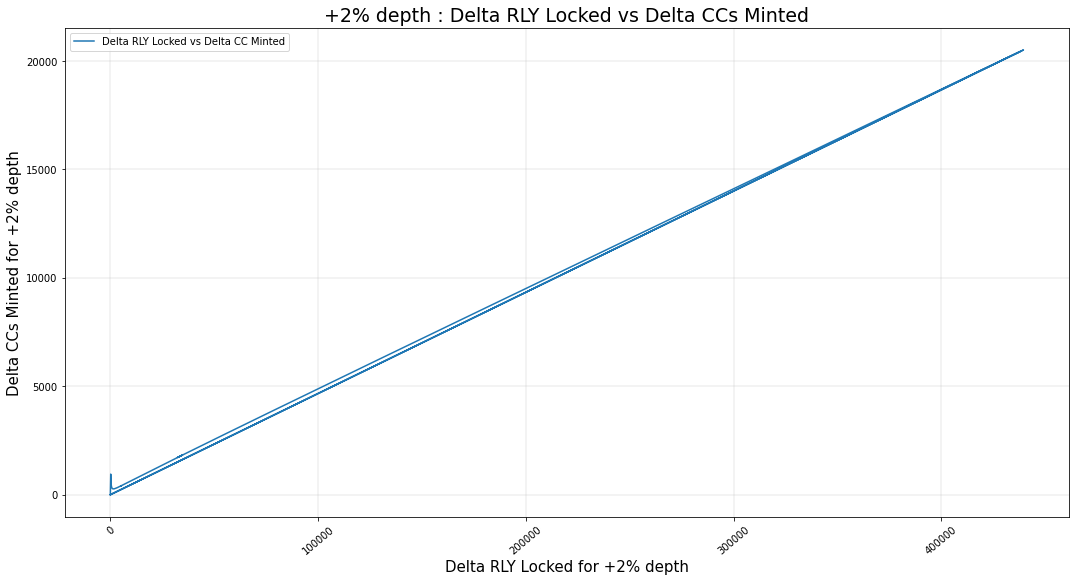

In [313]:
plt.figure(figsize=(18,9))
plt.xticks(rotation=40)
plt.grid(linewidth=0.3)
plt.plot(metrics.loc[:,'+2% depth: RLY Locked'],metrics.loc[:,'+2% depth: CCs Minted'],label='Delta RLY Locked vs Delta CC Minted')

plt.xlabel('Delta RLY Locked for +2% depth',fontsize = 15)
plt.ylabel('Delta CCs Minted for +2% depth',fontsize = 15)
plt.title('+2% depth : Delta RLY Locked vs Delta CCs Minted',fontsize = 19)
plt.legend()
# plt.savefig('./images/large_CC_TBC/4_posDepth_DeltaCC_vs_DeltaRLY.png')

In [317]:
# plt.figure(figsize=(18,9))
# plt.xticks(rotation=40)
# plt.grid(linewidth=0.3)
# plt.plot(metrics.loc[:,'CCs : Total Supply'],metrics.loc[:,'-2% depth: CCs Burnt'],label='-2% depth: CCs Burnt')
# plt.plot(metrics.loc[:,'CCs : Total Supply'],metrics.loc[:,'-2% depth: RLY Un-Locked'],label='-2% depth: RLY Un-Locked')

# plt.xlabel('CCs : Total Supply',fontsize = 15)
# plt.ylabel('Delta Supply (Millions)',fontsize = 15)
# plt.title('- 2% Depth : delta CCs burnt, RLY Un-Locked vs Total CC Supply',fontsize = 19)
# plt.legend()
# # plt.savefig('./images/large_CC_TBC/4_negDepthDeltaCC_RLY_vs_TotalCCSupply.png')

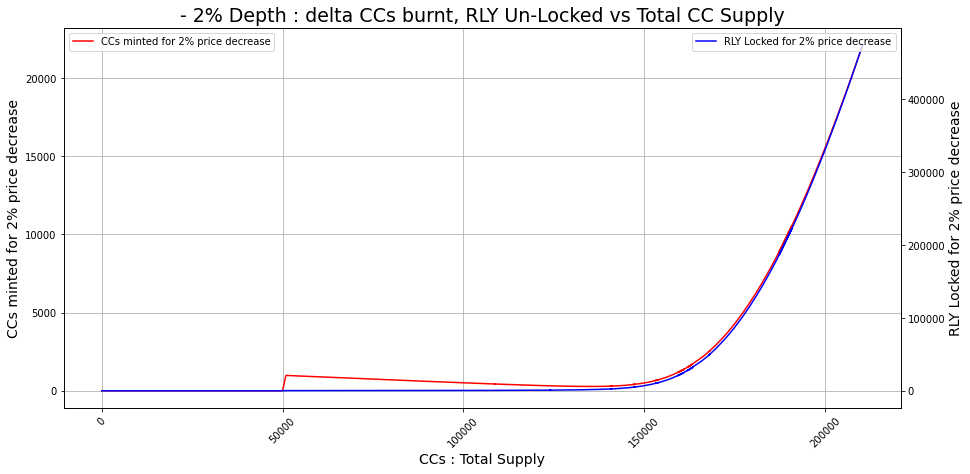

In [316]:
fig,ax = plt.subplots(figsize=(15, 7))
plt.xticks(rotation=45)
plt.title('- 2% Depth : delta CCs burnt, RLY Un-Locked vs Total CC Supply',fontsize = 19)

ax.plot(metrics.loc[:,'CCs : Total Supply'],metrics.loc[:,'-2% depth: CCs Burnt'], '-r',label="CCs minted for 2% price decrease")
ax.set_xlabel("CCs : Total Supply",fontsize=14)
ax.set_ylabel("CCs minted for 2% price decrease",fontsize=14)
ax.legend(loc='upper left')
ax.grid(True)

ax2=ax.twinx()
ax2.plot(metrics.loc[:,'CCs : Total Supply'],metrics.loc[:,'-2% depth: RLY Un-Locked'],'-b',label="RLY Locked for 2% price decrease")
ax2.set_ylabel("RLY Locked for 2% price decrease",fontsize=14)
ax2.legend(loc='upper right')

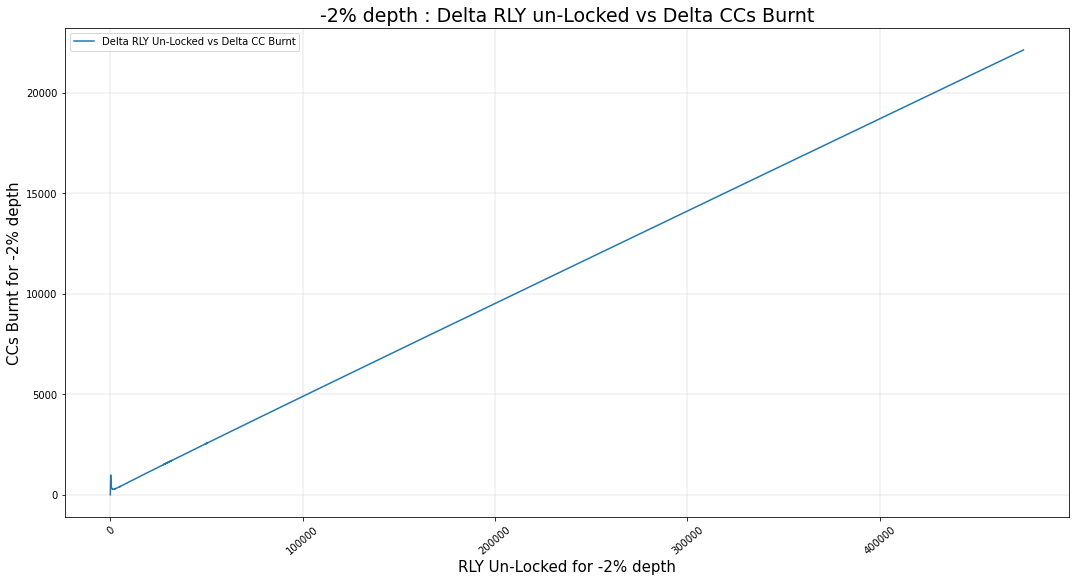

In [318]:
plt.figure(figsize=(18,9))
plt.xticks(rotation=40)
plt.grid(linewidth=0.3)
plt.plot(metrics.loc[:,'-2% depth: RLY Un-Locked'],metrics.loc[:,'-2% depth: CCs Burnt'],label='Delta RLY Un-Locked vs Delta CC Burnt')

plt.xlabel('RLY Un-Locked for -2% depth',fontsize = 15)
plt.ylabel('CCs Burnt for -2% depth',fontsize = 15)
plt.title('-2% depth : Delta RLY un-Locked vs Delta CCs Burnt',fontsize = 19)
plt.legend()
# plt.savefig('./images/large_CC_TBC/4_negDepth_DeltaCC_vs_DeltaRLY.png')

In [319]:
def getMillionConv(value):
    x = str(round(value/(10**3),1)) + ' K'
    return x

In [320]:
aggregatedDF = pd.DataFrame([], columns = ['Range (CC Supply)','Previous CC Supply','New CC Supply','RLY Locked',
                                           'RLY Locked (% of total)','Start Price','End Price','Price (mean)','Price (median)']) 

totalRLYLocked = metrics.loc[len(metrics.index) - 2,'RLY : Total Locked']
totalCCsSupply = metrics.loc[len(metrics.index) - 2,'CCs : Total Supply']
totalCCsMintedIterator = 0

depthFigures = pd.DataFrame([], columns = ['CCs : Total Supply','CCs : Price (RLY)',
                                 '+2% depth: CCs Minted','+2% depth: RLY Locked',
                                 '-2% depth: CCs Burnt','-2% depth: RLY Un-Locked']) 

i = 0 
while totalCCsMintedIterator < totalCCsSupply:
    CCsMintedIterator = 0
    RLY_locked_window = 0
    priceAvCalculator = 0
    startPrice = 0
    endPrice = 0
    
    while CCsMintedIterator < 25000: 
        if CCsMintedIterator == 0 :
            startPrice = metrics.loc[i,'CCs : Price (RLY)']

        CCsMintedIterator = CCsMintedIterator + metrics.loc[i,'CCs : Delta Supply']
        RLY_locked_window = RLY_locked_window + metrics.loc[i,'RLY : Delta Locked']  
        priceAvCalculator = priceAvCalculator + (metrics.loc[i,'CCs : Delta Supply'] * metrics.loc[i,'CCs : Price (RLY)'])
                
        if CCsMintedIterator >= 25000 :
            endPrice = metrics.loc[i,'CCs : Price (RLY)']
            
        i = i + 1
        if (i >= len(metrics.index)):
            i = i-1
            endPrice = metrics.loc[i-1,'CCs : Price (RLY)']
            break
        
#         print( 'Delta Supply = ' + str(round(metrics.loc[i,'CCs : Delta Supply'],2)) + ' Price (RLY) = ' + str(round(metrics.loc[i,'CCs : Price (RLY)'],2)) + ' priceAvCalculator = ' + str(priceAvCalculator) )
    
    price_mean = round(priceAvCalculator / CCsMintedIterator,4)
    price_median = (startPrice + endPrice)/2
#     print('\n price_av = ' + str(price_mean) + '  price_mean = ' + str(price_median) + ' \n')
    
    aggregatedDF.loc[len(aggregatedDF.index)] = [getMillionConv(totalCCsMintedIterator) + '-' + getMillionConv(totalCCsMintedIterator + CCsMintedIterator),
                                                 totalCCsMintedIterator,totalCCsMintedIterator + CCsMintedIterator, 
                                                 RLY_locked_window,str(round(100*RLY_locked_window/totalRLYLocked,2)) + ' %',
                                                startPrice, endPrice, price_mean, price_median  ]

    totalCCsMintedIterator = totalCCsMintedIterator + CCsMintedIterator 

    depthFigures.loc[len(depthFigures.index)] = metrics.loc[i,['CCs : Total Supply','CCs : Price (RLY)',
                                 '+2% depth: CCs Minted','+2% depth: RLY Locked',
                                 '-2% depth: CCs Burnt','-2% depth: RLY Un-Locked',
                                 'Reserve Ratio']]
    
    
    
depthFigures.loc[len(depthFigures.index)] = metrics.loc[len(metrics.index) - 1,['CCs : Total Supply','CCs : Price (RLY)',
                                 '+2% depth: CCs Minted','+2% depth: RLY Locked',
                                 '-2% depth: CCs Burnt','-2% depth: RLY Un-Locked',
                                 'Reserve Ratio']]    
    
    

In [321]:
display(aggregatedDF)

,Range (CC Supply),Previous CC Supply,New CC Supply,RLY Locked,RLY Locked (% of total),Start Price,End Price,Price (mean),Price (median)
0,0.0 K-50.0 K,0,50000,0,0.0 %,0,0,0.000,0.000
1,50.0 K-75.2 K,50000,75249.017,6261.045,0.44 %,0.187,0.334,0.253,0.261
2,75.2 K-100.4 K,75249.017,100365.617,12732.983,0.89 %,0.331,0.766,0.523,0.549
3,100.4 K-125.9 K,100365.617,125947.176,38918.329,2.72 %,0.765,2.918,1.600,1.841
4,125.9 K-151.9 K,125947.176,151881.616,207815.182,14.51 %,2.923,15.007,8.436,8.965
5,151.9 K-177.3 K,151881.616,177273.077,475832.112,33.23 %,15.948,20.658,19.030,18.303
6,177.3 K-203.1 K,177273.077,203065.917,546795.429,38.19 %,20.665,21.527,21.235,21.096
7,203.1 K-210.4 K,203065.917,210405.017,158359.756,11.06 %,21.53,21.615,21.585,21.572


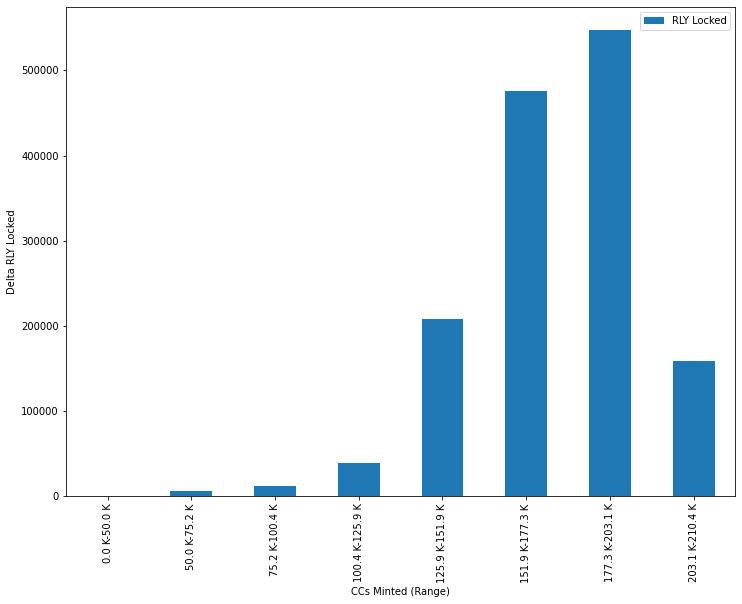

In [322]:
fig = aggregatedDF.plot.bar(x='Range (CC Supply)',y='RLY Locked',xlabel='CCs Minted (Range)',

                            ylabel='Delta RLY Locked', figsize=(12,9) ).get_figure()

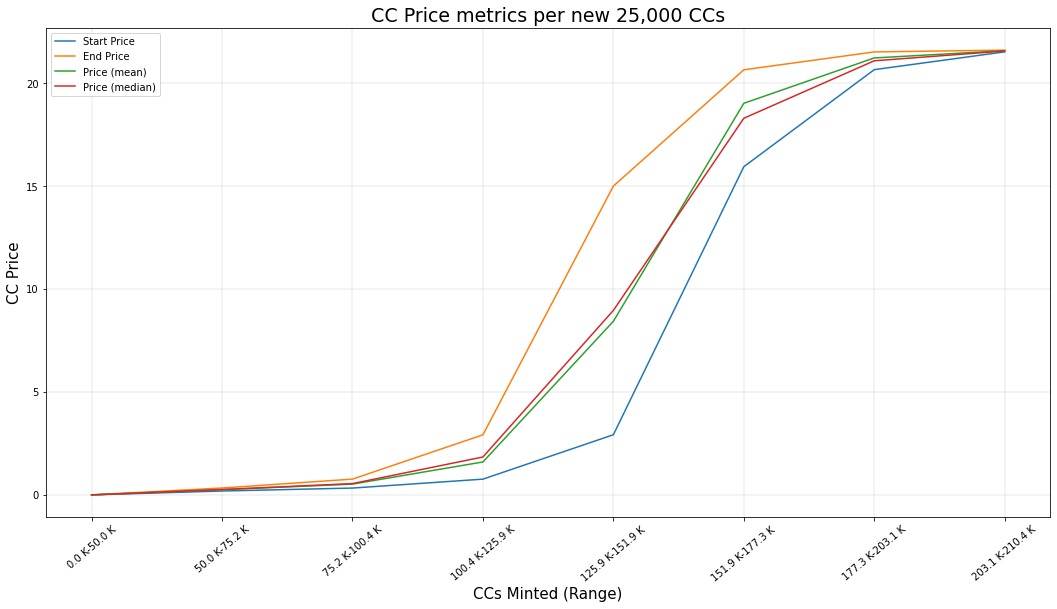

In [323]:
plt.figure(figsize=(18,9))
plt.xticks(rotation=40)
plt.grid(linewidth=0.3)
plt.plot(aggregatedDF.loc[:,'Range (CC Supply)'],aggregatedDF.loc[:,'Start Price'],label='Start Price')
plt.plot(aggregatedDF.loc[:,'Range (CC Supply)'],aggregatedDF.loc[:,'End Price'],label='End Price')
plt.plot(aggregatedDF.loc[:,'Range (CC Supply)'],aggregatedDF.loc[:,'Price (mean)'],label='Price (mean)')
plt.plot(aggregatedDF.loc[:,'Range (CC Supply)'],aggregatedDF.loc[:,'Price (median)'],label='Price (median)')

plt.xlabel('CCs Minted (Range)',fontsize = 15)
plt.ylabel('CC Price',fontsize = 15)
plt.title('CC Price metrics per new 25,000 CCs',fontsize = 19)
plt.legend()
plt.savefig('./images/large_CC_TBC/4_priceMetricsRange.png')